## Benchmark analysis across different curvatures

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from hyperdt.wrapped_normal_all_curvature import WrappedNormalMixture
from hyperdt.all_curvature_DT import HyperspaceDecisionTree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

INFO: Using numpy backend


In [3]:
def Minkowski_dot_product(v1, v2):
    return v1 @ v2 - 2 * v1[0] * v2[0]

### Experiments across different curvatures:
1. HyperDT accuracy vs. sklearn

2. Distribution of distances from cluster means

3. Pairwise distances in each cluster

In [4]:
NUM_CLASSES = 5
N_DIM = 2
SEED = 0
curvatures = [-5, -1, -0.5, -0.1, 0, 0.1, 0.5, 1, 5]
hypdt_scores = []
dt_scores = []
dists_by_curvature = []
pair_dists_by_curvature = []

for c in curvatures:
    # Generate data
    hyp = WrappedNormalMixture(num_points=1000, num_classes=NUM_CLASSES, n_dim=N_DIM, curvature=c, seed=SEED, cov_scale=0.3)
    X_hyp, y_hyp, X_hyp_means = hyp.generate_data()

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_hyp, y_hyp, test_size=0.2, random_state=0)

    # Fit hyperspace decision tree classifier
    hypdt = HyperspaceDecisionTree(max_depth=5, signed_curvature=c)
    hypdt.fit(X_train, y_train)
    hypdt_scores.append(hypdt.score(X_test, y_test))

    # Fit sklearn's decision tree classifier
    dt = DecisionTreeClassifier(max_depth=5)
    dt.fit(X_train, y_train)
    dt_scores.append(dt.score(X_test, y_test))

    # Distribution of distances from cluster centers
    dists = []
    for x, idx in zip(X_hyp, y_hyp):
        class_mean = X_hyp_means[idx]
        if c < 0:
            dists.append(np.arccosh(c * Minkowski_dot_product(x, class_mean)) / np.sqrt(abs(c)))
        elif c > 0:
            dists.append(np.arccos(c * np.dot(x, class_mean)) / np.sqrt(abs(c)))
        else:
            dists.append(np.linalg.norm(x - class_mean))
    dists_by_curvature.append(dists)

    # Compute average pairwise distance in each cluster
    avg_pairwise_dists = []
    for i in range(NUM_CLASSES):
        cluster = X_hyp[y_hyp == i]
        avg_pairwise_dists.append(np.mean([np.linalg.norm(cluster[j] - cluster[k])
                                           for j in range(len(cluster)) for k in range(j+1, len(cluster))]))
    pair_dists_by_curvature.append(avg_pairwise_dists)

### 1. Plot comparative accuracies for different curvatures

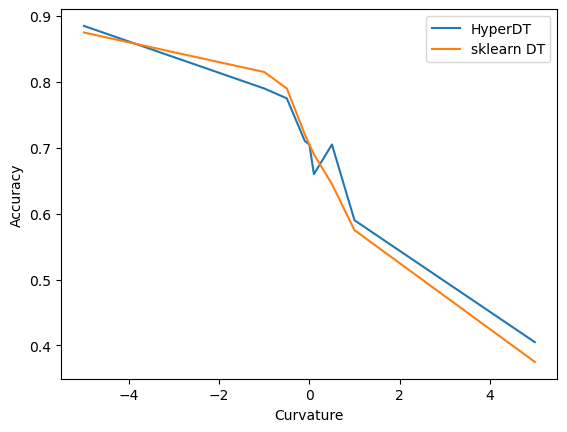

In [5]:
# Plot results
plt.plot(curvatures, hypdt_scores, label='HyperDT')
plt.plot(curvatures, dt_scores, label='sklearn DT')
plt.xlabel('Curvature')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 2. Plot distribution of distances from cluster means for different curvatures

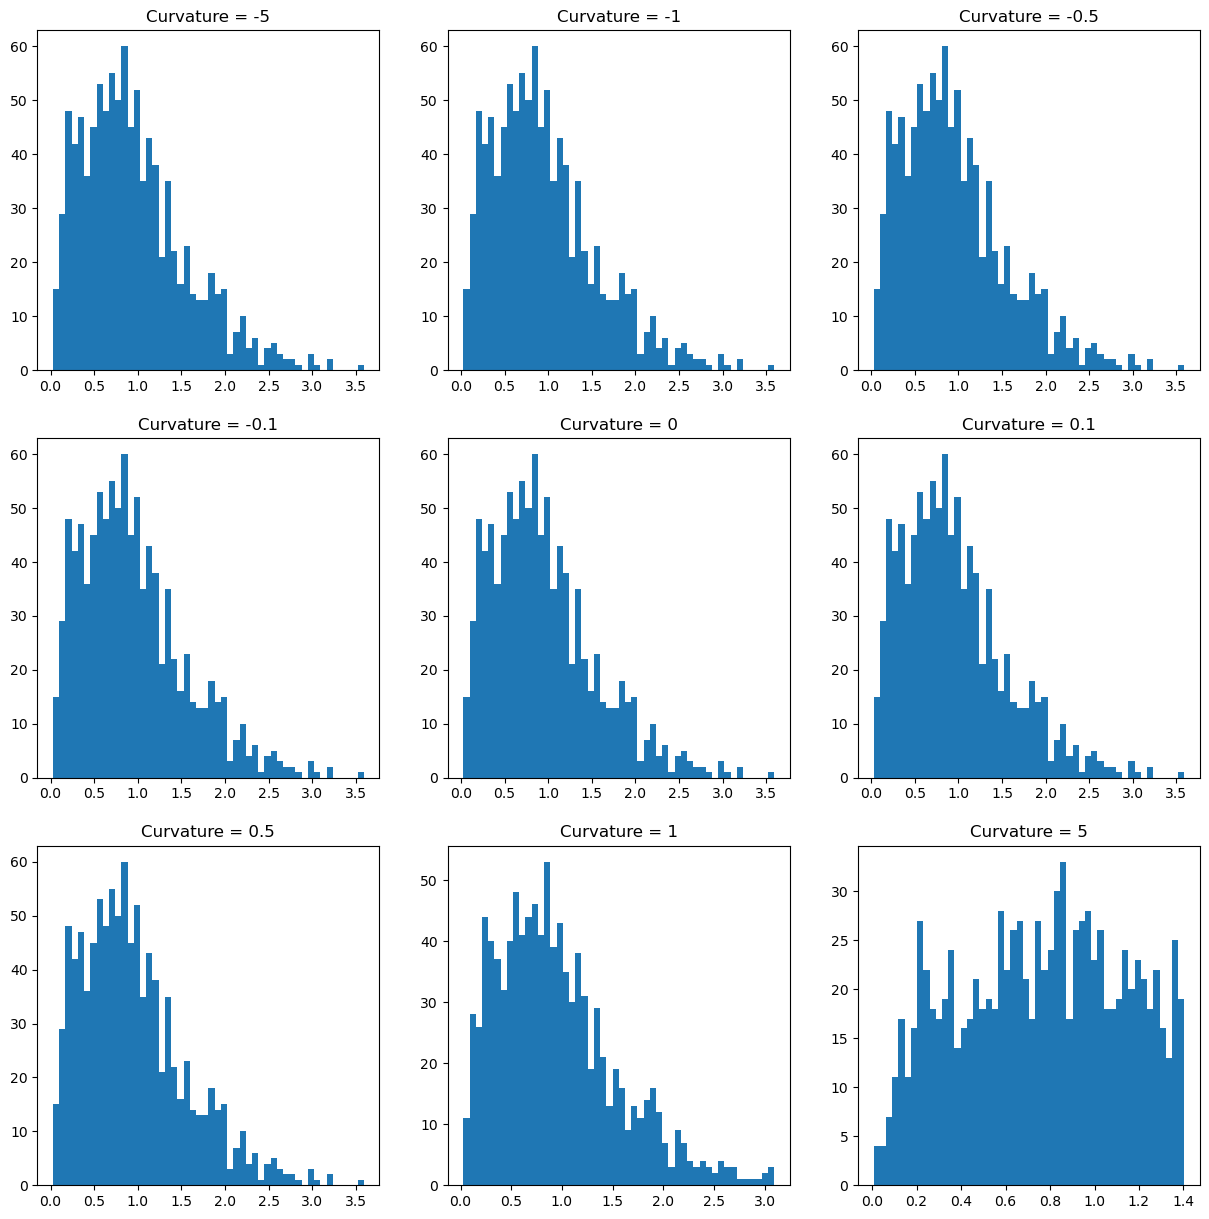

In [6]:
# Histogram of distances from cluster centers in subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i, ax in enumerate(axs.flat):
    ax.hist(dists_by_curvature[i], bins=50)
    ax.set_title(f'Curvature = {curvatures[i]}')
plt.show()

### 3. Plot pairwise distances in each cluster

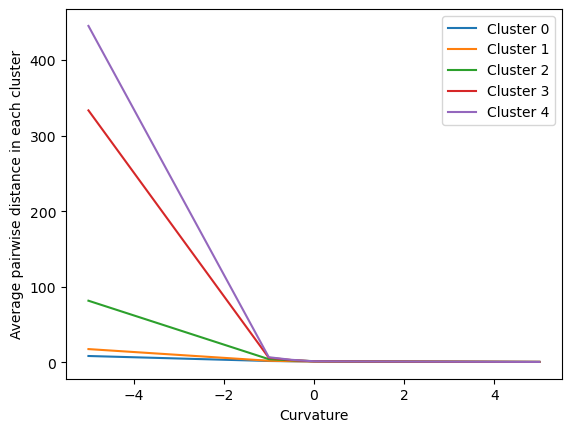

In [7]:
# Plot average pairwise distances in each cluster by curvature
plt.plot(curvatures, pair_dists_by_curvature)
plt.xlabel('Curvature')
plt.ylabel('Average pairwise distance in each cluster')
plt.legend([f'Cluster {i}' for i in range(NUM_CLASSES)])
plt.show()